In [3]:
import panel as pn
from panel.interact import interact
pn.extension()

import hvplot.pandas

import holoviews as hv
from holoviews import opts
hv.extension('bokeh')

import pandas as pd


In [2]:

#Import des portefeuilles

ALL_Portfolio = pd.read_excel(r'C:\Sharepoint GIP\Gestion Indépendante de patrimoines GIP SA\Docs - Documents\gip sa\Scripts\Risk\Data_Raw\ALL_PORTEFEUILLE_GIP_ANONYME.xlsx')

#Renommer la colonne code portefeuille

ALL_Portfolio = ALL_Portfolio.rename(columns={'Code/Numéro/Contrat': 'Code'})



In [4]:
#IMport liste de titres
#Import closing price

Titres = pd.read_excel(r'C:\Sharepoint GIP\Gestion Indépendante de patrimoines GIP SA\Docs - Documents\datas\Liste Titres CRM\ListeTitres (Pour importation CRM).xlsx')
ALL_CLOSING_Price = pd.read_excel(r'C:\Sharepoint GIP\Gestion Indépendante de patrimoines GIP SA\Docs - Documents\gip sa\Scripts\Risk\Data_Raw\ALL_CLOSE_PRICE_GIP.xlsx')


In [5]:
Historique_Vol = 20  #remplir dropdown menu datalore

In [18]:
import pandas as pd
import panel as pn

pn.extension()

# Exemple de données (remplacez-le par votre propre DataFrame)
# ALL_Portfolio = pd.read_csv("path_to_your_data.csv")

# Créer le widget de sélection du portefeuille
Portfolio_code = list(ALL_Portfolio['Code portefeuille'].unique())
dropdown = pn.widgets.Select(name='Sélectionner un portefeuille', options=Portfolio_code)

# Créer un panneau pour afficher le DataFrame
df_pane = pn.pane.DataFrame(pd.DataFrame())  # Initialiser un DataFrame vide

df_Total_pane = pn.pane.DataFrame(pd.DataFrame())  # Initialiser un DataFrame vide

# Fonction pour mettre à jour le portefeuille sélectionné à partir du dropdown
def update_selected_portfolio(event):
    portfolio_code = event.new  # Valeur sélectionnée dans le dropdown
    Selected_Portfolio = ALL_Portfolio[
        ALL_Portfolio['Code portefeuille'] == portfolio_code
    ].copy()

    # Suppression des colonnes indésirables
    columns_to_remove = [
        'Dépositaire', 'Code gestionnaire', 'Mode de gestion', 'Profil de gestion', 
        'Taux', 'Echéance', 'Intérêts courus', 'Intérêts courus en  (mon. réf.)', 
        'PP non réal. en % Orig.', 'PP non réal. en %  (mon. réf.)'
    ]
    Selected_Portfolio.drop(columns=columns_to_remove, inplace=True, errors='ignore')

    # Calculer la valeur totale du marché du portefeuille sélectionné
    total_selected_portfolio = Selected_Portfolio['Valeur marché en  (mon. réf.)'].sum()

    # Ajouter la colonne 'Pondération'
    Selected_Portfolio['Pondération'] = (
        Selected_Portfolio['Valeur marché en  (mon. réf.)'] / total_selected_portfolio
    ).round(2)

    df_Total_pane.object = Selected_Portfolio
    

    # Exclusion des liquidités
    Selected_Portfolio_Ex_Cash = Selected_Portfolio[Selected_Portfolio['Catégorie'] != 'Liquidités'].copy()

    # Recalculer la valeur totale de marché après exclusion des liquidités
    total_selected_portfolio_Ex_Cash = Selected_Portfolio_Ex_Cash['Valeur marché en  (mon. réf.)'].sum()

    # Recalculer les pondérations sans les liquidités
    Selected_Portfolio_Ex_Cash['Pondération'] = (
        Selected_Portfolio_Ex_Cash['Valeur marché en  (mon. réf.)'] / total_selected_portfolio_Ex_Cash
    ).round(2)

    # Mettre à jour l'affichage du DataFrame avec le tableau actualisé
    df_pane.object = Selected_Portfolio_Ex_Cash  # Mettre à jour l'objet avec les données actualisées

# Surveiller les changements dans le menu déroulant
dropdown.param.watch(update_selected_portfolio, 'value')

# Afficher le menu déroulant et le DataFrame

test_2 = pn.Column(dropdown, df_Total_pane)

test_2


Column
    [0] Select(name='Sélectionner u..., options=[np.int64(104401), ...], value=np.int64(104401))
    [1] DataFrame(DataFrame)

In [19]:
# Filtrer les prix de clôture pour le portefeuille sélectionné
Closing_price_selected_portfolio = ALL_CLOSING_Price[
    ALL_CLOSING_Price['Code'].isin(df_pane.object['Code'])
]

# Sélectionner les X derniers jours (Historique_Vol)
Histo_Closing_price_selected_portfolio = Closing_price_selected_portfolio.iloc[:, -Historique_Vol:]

# Remplir les valeurs manquantes (forward fill)
Histo_Closing_price_selected_portfolio = Histo_Closing_price_selected_portfolio.ffill()

# Calculer les variations journalières en pourcentage
Histo_Closing_price_selected_portfolio_percent = (
        Histo_Closing_price_selected_portfolio.pct_change(axis=1, fill_method=None) * 100
).round(2)

# Ajouter la colonne 'Code' pour garder une référence des actifs
Histo_Vol_ISIN_percent = pd.concat(
    [Closing_price_selected_portfolio['Code'], Histo_Closing_price_selected_portfolio_percent],
    axis=1
)

# Calculer la volatilité (écart-type des variations) pour chaque actif
Histo_Vol_ISIN_percent['Volatilité'] = Histo_Vol_ISIN_percent.iloc[:, 1:].std(axis=1).round(2)





In [20]:
# Transposer les variations pour aligner les actifs en colonnes
variations_transposées = Histo_Vol_ISIN_percent.iloc[:, 1:-1].T  # Exclure 'Code' et 'Volatilité'

# Nommer les colonnes de la matrice transposée avec les ISIN (valeurs de la première colonne)
variations_transposées.columns = Histo_Vol_ISIN_percent['Code']

# Calculer la matrice de corrélation entre les actifs
matrice_corr = variations_transposées.corr()




Text(0.5, 1.0, 'Matrice de Corrélation des Actifs (ISIN)')

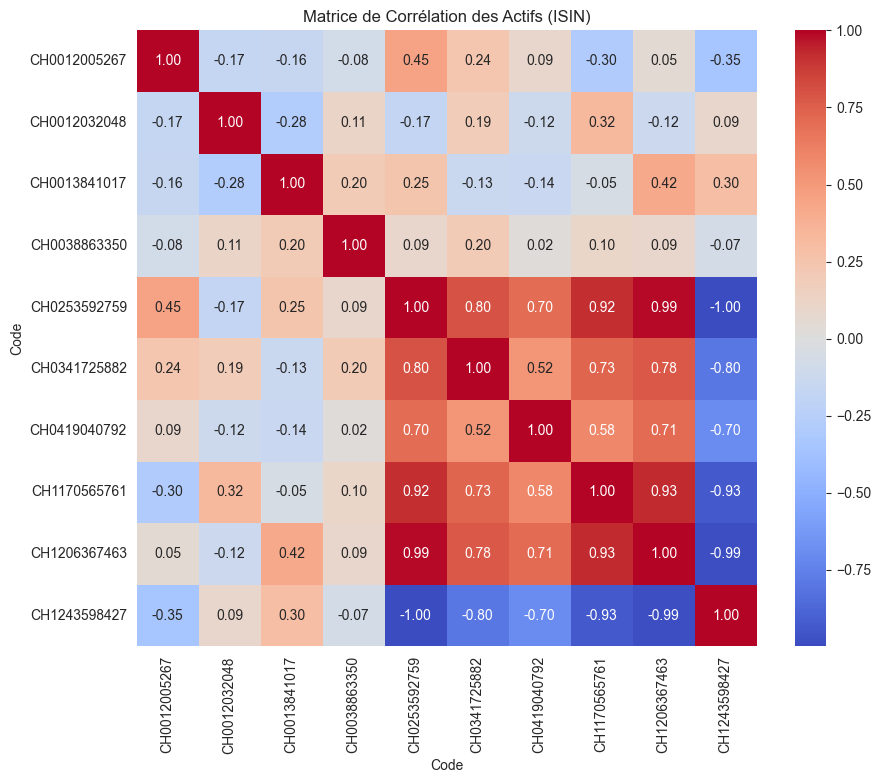

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Créer une figure et un axe pour le graphique
Correlation_chart, ax = plt.subplots(figsize=(10, 8))

# Générer la heatmap
sns.heatmap(
    matrice_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    xticklabels=matrice_corr.columns,
    yticklabels=matrice_corr.index,
    ax=ax
)

# Ajouter un titre
ax.set_title("Matrice de Corrélation des Actifs (ISIN)")


In [22]:
import numpy as np

# Assurez-vous que 'Pondération' existe dans df_pane.object
Ponderation_Ex_Cash = df_pane.object['Pondération'] / 100  # Diviser les pondérations en pourcentage par 100

# Supprimer la colonne "Code" (identifiant)
Price_Variations = Histo_Vol_ISIN_percent.drop(columns=['Code'])

# Transposer la matrice
Price_Variations_T = Price_Variations.copy().T

# Calculer la matrice de covariance annualisée
Matrix_Cov = Price_Variations_T.cov() * 252

# Calcul de la variance du portefeuille
Variance_Portfolio_Ex_Cash = np.dot(
    Ponderation_Ex_Cash, np.dot(Matrix_Cov.values, Ponderation_Ex_Cash)
)

# Calculer la volatilité hors liquidités
Volatilite_Selected_Portfolio_Ex_Cash = np.sqrt(Variance_Portfolio_Ex_Cash).round(4)

# Filtrer les lignes correspondant aux liquidités
Cash = df_pane.object[df_pane.object['Catégorie'] == 'Liquidités']

# Calculer la pondération totale des liquidités
Ponderation_Cash = Cash['Pondération'].sum()

# Calculer la volatilité totale du portefeuille
Volatilite_Selected_Portfolio = (1 - Ponderation_Cash) * Volatilite_Selected_Portfolio_Ex_Cash

Volatilite_Selected_Portfolio




np.float64(0.0691)